In [1]:
import sys
import os

# Add the parent folder of 'src' to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(""), '..', 'src')))

In [2]:
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download('universal_tagset')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset 

True

In [3]:
%pip install ir_datasets numpy matplotlib seaborn scikit-learn scipy wordcloud

import ir_datasets
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ir_datasets in c:\users\franc\appdata\local\programs\python\python312\lib\site-packages (0.5.10)



c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 10, silhouette score: 0.0099
Reducing TF-IDF dimensions with TruncatedSVD...
Running t-SNE on reduced dimensions...
Plotting t-SNE results...


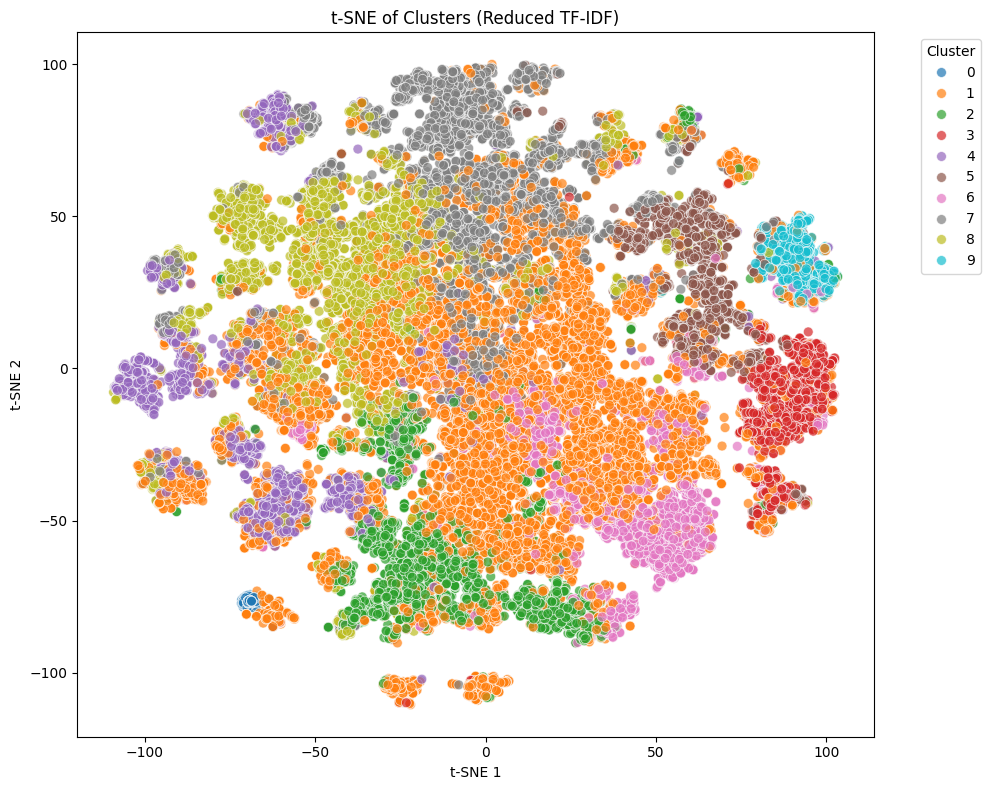


Cluster 2:
  Medoid Doc ID: 9z3ppxph
  Top Terms (TF-IDF): influenza, respiratory, children, viruses, patients, virus, infections, viral, rsv, infection
  Divergent Terms (KL Contribution):
    - influenza: 2.9124e-02
    - respiratory: 1.8658e-02
    - children: 1.3949e-02
    - rsv: 9.8020e-03
    - infections: 8.2623e-03
    - viruses: 7.4586e-03
    - h1n1: 7.3414e-03
    - patients: 7.0468e-03
    - tract: 6.5503e-03
    - rhinovirus: 5.1027e-03
  Total KL Divergence: 0.5480

Cluster 1:
  Medoid Doc ID: u2mfjhtj
  Top Terms (TF-IDF): disease, patients, virus, human, diseases, infection, clinical, based, study, new
  Divergent Terms (KL Contribution):
    - la: 9.2066e-04
    - en: 7.0984e-04
    - chapter: 5.0063e-04
    - applications: 4.9020e-04
    - species: 4.5604e-04
    - compounds: 4.5262e-04
    - cats: 4.3901e-04
    - drug: 4.3593e-04
    - des: 4.3534e-04
    - rats: 4.3160e-04
  Total KL Divergence: 0.1260

Cluster 5:
  Medoid Doc ID: nq2mscyk
  Top Terms (TF-IDF): s

In [4]:
from clusters import clustering, interpret, evaluate, compute_global_centroid, compute_global_centroid_represent_cluster
from plots import plot_cluster_divergence, plot_top_divergent_terms, plot_cluster_kl_divergence, plot_tsne, plot_wordcloud
import ir_datasets

# Load dataset and extract docs used in clustering
dataset = ir_datasets.load("cord19/trec-covid/round1")
all_docs = [(doc.doc_id, f"{doc.title or ''} {doc.abstract or ''}") 
            for doc in dataset.docs_iter() if doc.abstract]
all_doc_ids, all_texts = zip(*all_docs)

# Run clustering and reuse vectorizer
clusters, vectorizer, X = clustering(dataset.docs_iter())

# Recompute global centroid using the same vectorizer
global_centroid = compute_global_centroid_represent_cluster(dataset.docs_iter(), vectorizer)

# Build map: doc_id → cluster label
flat_cluster_dict = {doc_id: label for label, cluster in clusters for doc_id in cluster}

# Select indices from all_doc_ids that match clustered ones
filtered_indices = [i for i, doc_id in enumerate(all_doc_ids) if doc_id in flat_cluster_dict]
X_filtered = X[filtered_indices]
labels_filtered = [flat_cluster_dict[all_doc_ids[i]] for i in filtered_indices]

# Plot t-SNE
plot_tsne(X_filtered, labels_filtered)

# Store cluster-level info
cluster_labels = []
kl_divergences = []
label_summaries = []

# Interpret each cluster
for cluster in clusters:
    interpretation = interpret(
        cluster,
        dataset.docs_iter(),
        global_centroid=global_centroid,
        global_vectorizer=vectorizer
    )

    print(f"\nCluster {cluster[0]}:")
    print(f"  Medoid Doc ID: {interpretation['medoid']}")
    print(f"  Top Terms (TF-IDF): {', '.join(interpretation['top_terms'])}")
    print("  Divergent Terms (KL Contribution):")
    for term, score in zip(interpretation['divergent_terms'], interpretation['divergent_scores']):
        print(f"    - {term}: {score:.4e}")
    print(f"  Total KL Divergence: {interpretation['kl_divergence']:.4f}")

    # Optionally: plot_wordcloud(interpretation['divergent_terms'], interpretation['divergent_scores'])

    cluster_labels.append(f"Cluster {cluster[0]}")
    kl_divergences.append(interpretation['kl_divergence'])
    label_summaries.append(" / ".join(interpretation['divergent_terms'][:3]))


